# get marked slides

slides info are collected '../config/blca.xlsx',infos of each slide is documented in one line, and well-marked slides are colored in yellow.
well-marked slides are those with relatively definite borders and arranged in chunk, which are easy to annotate. those with unrecognized borders & arranged in many small pieces are excluded and colored in red.
by extracting those slides colored with yellow, we get slides for next step, i.e. patch extraction

In [1]:
import openpyxl
import numpy as np
from openpyxl import load_workbook
import pandas as pd
from func import visualization

In [2]:
def show_info(x,show_values = False):
    length = 'no length'
    keys = 'not a dict'
    values = 'not a dict'
    shape = 'not a ndarray'
    size = 'not a ndarray'
    if hasattr(x,'__len__'):
        length = len(x)
    if isinstance(x,dict):
        keys = x.keys()
        values = x.values()
    if type(x) is np.ndarray:
        shape = x.shape
        size = x.size
    print(f'type:{type(x)} \nlen:{length}\nshape:{shape}\nsize:{size}\nkeys:{keys}\noriginal info:{x}')
    if show_values:
        print(f'\nvalues:{values}')

## 提取下一步需要的uuid

In [3]:
from dis import show_code

wb = load_workbook('../config/blca.xlsx')
ws = wb['Sheet1']
dir_uuid = ws['A']


included_svs_uuid = []  #最终用于切片的uuid列表,eg:d2e43ec6-5027-4f2c-932b-28a681da7cd9
index = []
included_file_svs = []  #与uuid对应的file_svs列表,eg:TCGA-2F-A9KO-01Z-00-DX1
for i,cell in enumerate(dir_uuid[1:]):
    if cell.fill.fgColor.rgb == 'FFFFFF00':  #这个函数只能读取标准色
        included_svs_uuid.append(cell.value)
        index.append(i)
for i in index:
    included_file_svs.append(ws['B'][1:][i].value)
    
# 386 well marked slides in total

/home/wangyh/miniconda3/envs/patho_AI/lib/python3.8/site-packages/openpyxl/reader/excel.py:228: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


## 将TMB与uuid对应起来

In [4]:
pan_TMB = pd.read_csv('../config/TCGA TMB.csv')  # read TMBs in existing file
# BLCA_TMB = pan_TMB[pan_TMB['']]
BLCA_TMB = pan_TMB[pan_TMB['Cohort'] == 'BLCA']  # get TMB of BLCA

BLCA_TMB['TMB_H/L'] = 'L'   # divide TMB of BLCA cases into high / low by cutpoint 10
for i,tmb in BLCA_TMB['TMB'].items():
    if tmb >= 10:
        BLCA_TMB['TMB_H/L'][i] = 'H'

# BLCA_TMB contains 409 cases.
        
BLCA_TMB_final = BLCA_TMB[['Tumor_Sample_ID','TMB_H/L']]  # extract case_names(Tumor_Sample_ID,eg TCGA-FD-A43S-01) & corresponding TMB.
BLCA_TMB_final
# BLCA_TMB_final.to_csv('../config/TMB_uuid.csv')

/tmp/ipykernel_2829949/2929878655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BLCA_TMB['TMB_H/L'] = 'L'   # divide TMB of BLCA cases into high / low by cutpoint 10
/tmp/ipykernel_2829949/2929878655.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BLCA_TMB['TMB_H/L'][i] = 'H'


,Tumor_Sample_ID,TMB_H/L
91,TCGA-FD-A43S-01,L
92,TCGA-XF-AAN8-01,L
93,TCGA-4Z-AA7N-01,L
94,TCGA-DK-A3WY-01,L
95,TCGA-XF-AAME-01,L
...,...,...
495,TCGA-DK-A3WW-01,H
496,TCGA-DK-A1AC-01,H
497,TCGA-YC-A89H-01,H
498,TCGA-MV-A51V-01,H


## 将uuid、file_svs写进csv

In [5]:
svs_with_labels = pd.DataFrame({
    'dir_uuid':included_svs_uuid,
    'file_svs':included_file_svs})

#included_file_svs are arranged as TCGA-2F-A9KO-01Z-00-DX1, first 15 syllables represents patient number, the remnants represents infos of the very slide.
#extract sample ID for better corresponding to TMB H/:L
def get_sampleID(string):
    sampleID = string[:15]
    return sampleID

svs_with_labels['file_svs'] = svs_with_labels['file_svs'].apply(get_sampleID)
svs_with_labels


,dir_uuid,file_svs
0,d2e43ec6-5027-4f2c-932b-28a681da7cd9,TCGA-2F-A9KO-01
1,bff29d20-3a8f-4a5d-a2de-0e142390551d,TCGA-2F-A9KP-01
2,edcf4ae6-c985-40ad-aff4-a0ce31b46aeb,TCGA-2F-A9KP-01
3,e20c2176-2b57-4cc9-a68a-eb6933bf60b1,TCGA-2F-A9KQ-01
4,a085fe18-1709-417a-a779-fe69f5964766,TCGA-2F-A9KR-01
...,...,...
381,6d94e519-6dea-42d0-a505-f36ab27f2f3f,TCGA-ZF-AA54-01
382,16c68e40-fc90-495a-b856-fe1f11f82143,TCGA-ZF-AA58-01
383,ff7d6bdf-b564-41e0-b3e5-2a649423796b,TCGA-ZF-AA5H-01
384,f7db97bf-bcb4-4383-afe2-36f549a0bdf0,TCGA-ZF-AA5N-01


## merge

## 1. merge dir_uuid, tumor sample ID and TMB H/L

In [6]:
df_1 = pd.merge(svs_with_labels,BLCA_TMB_final,left_on='file_svs',right_on='Tumor_Sample_ID',how = 'left')
df_1

,dir_uuid,file_svs,Tumor_Sample_ID,TMB_H/L
0,d2e43ec6-5027-4f2c-932b-28a681da7cd9,TCGA-2F-A9KO-01,TCGA-2F-A9KO-01,H
1,bff29d20-3a8f-4a5d-a2de-0e142390551d,TCGA-2F-A9KP-01,TCGA-2F-A9KP-01,L
2,edcf4ae6-c985-40ad-aff4-a0ce31b46aeb,TCGA-2F-A9KP-01,TCGA-2F-A9KP-01,L
3,e20c2176-2b57-4cc9-a68a-eb6933bf60b1,TCGA-2F-A9KQ-01,TCGA-2F-A9KQ-01,L
4,a085fe18-1709-417a-a779-fe69f5964766,TCGA-2F-A9KR-01,TCGA-2F-A9KR-01,L
...,...,...,...,...
381,6d94e519-6dea-42d0-a505-f36ab27f2f3f,TCGA-ZF-AA54-01,TCGA-ZF-AA54-01,L
382,16c68e40-fc90-495a-b856-fe1f11f82143,TCGA-ZF-AA58-01,TCGA-ZF-AA58-01,L
383,ff7d6bdf-b564-41e0-b3e5-2a649423796b,TCGA-ZF-AA5H-01,TCGA-ZF-AA5H-01,L
384,f7db97bf-bcb4-4383-afe2-36f549a0bdf0,TCGA-ZF-AA5N-01,TCGA-ZF-AA5N-01,L


origin of full csv

In [ ]:
# df = pd.read_csv('./config/TMB_uuid.csv')
# uuid = df['dir_uuid']
# def svs_path_generator(uuid):
#     return glob.glob(f"/mnt/wangyh/TCGA_svs/{uuid}/*.svs")[0]
# svs_paths = uuid.apply(svs_path_generator)
# # svs_paths = [glob.glob(f"{working_dir}/TCGA_svs/TCGA_bladder/{x}/*.svs")[0] for x in uuid]
# #改一下实现方法
# svs_labels = df["TMB_H/L"]
# df['svs_paths']=svs_paths


# df.to_csv('full.csv')  381 lines in total,meaning 5 well marked slides has no corresponding TMB value

## 2. merge dir_uuid and corresponding patch number after CN

### get patch number under different magnificant scales

In [8]:
import glob

def count_patches(uuid):
    for i in uuid:
        x5 = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/5X/T*')
        x10 = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/10X/T*')
        x20 = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/20X/T*')
        x40 = glob.glob(f'/mnt/wangyh/CN_patches/*/{uuid}/40X/T*')
    return len(x5),len(x10),len(x20),len(x40)

uuid = df_1['dir_uuid']

### find out those with limited patches extracted, which may be not well marked / not appropriate view of slide

In [ ]:
# dic_count = {}
# not_well_marked = {}
# for i in uuid:
#     if count_patches(i)[3] < 100:
#         not_well_marked[i] = count_patches(i)
#     else:
#         dic_count[i] = count_patches(i)

In [12]:
# np.save('../config/extract_patches_info/well_marked_slides.npy',dic_count)
# np.save('../config/extract_patches_info/not_well_marked_slides.npy',not_well_marked)

In [9]:
not_well_marked = np.load('not_well_marked_slides.npy',allow_pickle=True).item()
well_marked = np.load('well_marked_slides.npy',allow_pickle=True).item()

In [46]:
out = {**not_well_marked,**well_marked}
out_df = pd.DataFrame(out).T
out_df.columns = ['5x','10x','20x','40x']
out_df['dir_uuid'] = out_df.index
out_df.index = range(386)
out_df

,5x,10x,20x,40x,dir_uuid
0,3,6,12,77,e20c2176-2b57-4cc9-a68a-eb6933bf60b1
1,0,0,2,16,cf1884cf-8262-45b4-841a-e1ef212c0a3a
2,0,0,0,0,742b49e2-5763-42e5-b535-2b273e498f6f
3,0,0,0,0,38739fe8-8b25-4066-966d-1bb225ae13c1
4,0,0,0,0,98a97692-4eee-463f-90bf-20f8446e4533
...,...,...,...,...,...
381,153,583,862,167,6d94e519-6dea-42d0-a505-f36ab27f2f3f
382,47,169,661,2740,16c68e40-fc90-495a-b856-fe1f11f82143
383,27,49,153,723,ff7d6bdf-b564-41e0-b3e5-2a649423796b
384,112,504,2178,9291,f7db97bf-bcb4-4383-afe2-36f549a0bdf0


In [19]:
full = pd.read_csv('../config/full.csv')
full = full.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

,dir_uuid,file_svs,Tumor_Sample_ID,TMB_H/L,svs_paths
0,d2e43ec6-5027-4f2c-932b-28a681da7cd9,TCGA-2F-A9KO-01,TCGA-2F-A9KO-01,H,/mnt/wangyh/TCGA_svs/d2e43ec6-5027-4f2c-932b-2...
1,bff29d20-3a8f-4a5d-a2de-0e142390551d,TCGA-2F-A9KP-01,TCGA-2F-A9KP-01,L,/mnt/wangyh/TCGA_svs/bff29d20-3a8f-4a5d-a2de-0...
2,edcf4ae6-c985-40ad-aff4-a0ce31b46aeb,TCGA-2F-A9KP-01,TCGA-2F-A9KP-01,L,/mnt/wangyh/TCGA_svs/edcf4ae6-c985-40ad-aff4-a...
3,e20c2176-2b57-4cc9-a68a-eb6933bf60b1,TCGA-2F-A9KQ-01,TCGA-2F-A9KQ-01,L,/mnt/wangyh/TCGA_svs/e20c2176-2b57-4cc9-a68a-e...
4,a085fe18-1709-417a-a779-fe69f5964766,TCGA-2F-A9KR-01,TCGA-2F-A9KR-01,L,/mnt/wangyh/TCGA_svs/a085fe18-1709-417a-a779-f...
...,...,...,...,...,...
376,6d94e519-6dea-42d0-a505-f36ab27f2f3f,TCGA-ZF-AA54-01,TCGA-ZF-AA54-01,L,/mnt/wangyh/TCGA_svs/6d94e519-6dea-42d0-a505-f...
377,16c68e40-fc90-495a-b856-fe1f11f82143,TCGA-ZF-AA58-01,TCGA-ZF-AA58-01,L,/mnt/wangyh/TCGA_svs/16c68e40-fc90-495a-b856-f...
378,ff7d6bdf-b564-41e0-b3e5-2a649423796b,TCGA-ZF-AA5H-01,TCGA-ZF-AA5H-01,L,/mnt/wangyh/TCGA_svs/ff7d6bdf-b564-41e0-b3e5-2...
379,f7db97bf-bcb4-4383-afe2-36f549a0bdf0,TCGA-ZF-AA5N-01,TCGA-ZF-AA5N-01,L,/mnt/wangyh/TCGA_svs/f7db97bf-bcb4-4383-afe2-3...


In [51]:
full_merged = pd.merge(out_df,full,how = 'right')
full_merged = full_merged[['dir_uuid','Tumor_Sample_ID','TMB_H/L','5x','10x','20x','40x']]
# full_merged.to_csv('../config/patch_info.csv')

In [17]:
not_well_marked['7a0697d9-18db-4e52-b243-be06879a9944']

(0, 0, 0, 0)

In [7]:
len((not_well_marked.keys()))

27

In [10]:
ls_Not = list(not_well_marked.keys())
ls_Not

['e20c2176-2b57-4cc9-a68a-eb6933bf60b1',
 'cf1884cf-8262-45b4-841a-e1ef212c0a3a',
 '742b49e2-5763-42e5-b535-2b273e498f6f',
 '38739fe8-8b25-4066-966d-1bb225ae13c1',
 '98a97692-4eee-463f-90bf-20f8446e4533',
 '106db19d-cd3d-49a6-96fd-d2c244713124',
 '0564ad3d-feb1-4281-8086-342c6b2d28ab',
 '4e0859ed-94a0-4e14-ab35-2fa7534073c5',
 '7a0697d9-18db-4e52-b243-be06879a9944',
 'b86586d0-ba09-4058-8595-63520d4d1b9e',
 '4962c0e1-8fb7-4d01-ab55-490f513ec623',
 '95cbd3e7-5d6a-428a-a2de-1c20b56896f6',
 'da73748f-0c9d-47ed-9803-7e8001542917',
 '474e93f2-2ee8-478d-9a87-ab561286535f',
 '706b61dc-f3e5-4a5d-850f-d6e223388b15',
 '27f74719-9ef9-4b54-a19e-e9182e19b06e',
 '6c3a7875-2041-4f7f-94be-a69a22b366d9',
 'f9cee804-1f30-4a97-b5ae-55cf24ad220e',
 'bd951d94-8a5c-4bd5-a168-7f80b55d2f1b',
 '28ebbb69-6d0c-43aa-af53-19d268eaf6bd',
 '24790043-229c-4158-8fb8-c26da3ffa38a',
 '4b860476-9bac-40c6-b6ea-8c1aaec737e1',
 '8cf7efe0-f20f-4937-b8c3-44a78c3e2174',
 'e3c39d18-255d-4e17-aca5-af519ec7ff4f',
 '0f58bf66-d0e7-

In [24]:
import importlib
importlib.reload(visualization)

<module 'func.visualization' from '/home/wangyh/uro_biomarker/patho_AI/processing/func/visualization.py'>

/home/wangyh/uro_biomarker/patho_AI/processing/extract_patches_nonT.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.array(mask_coords[cls])


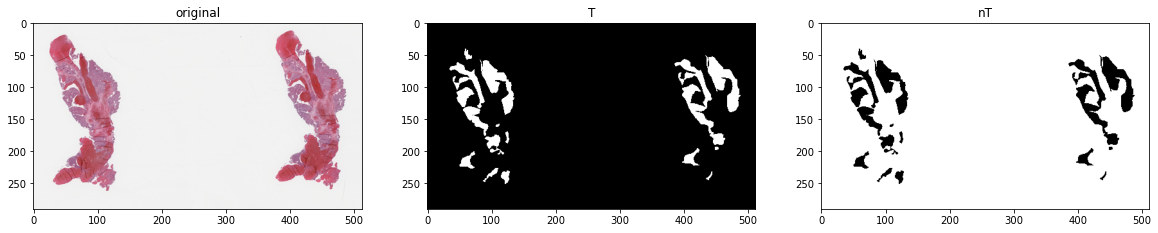

In [49]:
# og,T,nT = visualization.show_wsi_with_mark('742b49e2-5763-42e5-b535-2b273e498f6f',get_pic=True)

In [ ]:
figseq,titles = visualization.show_wsis_with_marks(ls_Not,figsize = (20,100),ret = True)

  0%|          | 0/27 [00:00<?, ?it/s]

start drawing e20c2176-2b57-4cc9-a68a-eb6933bf60b1


/home/wangyh/uro_biomarker/patho_AI/processing/extract_patches_nonT.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.array(mask_coords[cls])
  4%|▎         | 1/27 [07:28<3:14:25, 448.68s/it]

start drawing cf1884cf-8262-45b4-841a-e1ef212c0a3a


  7%|▋         | 2/27 [13:52<2:51:06, 410.67s/it]

start drawing 742b49e2-5763-42e5-b535-2b273e498f6f


 11%|█         | 3/27 [20:18<2:39:47, 399.47s/it]

start drawing 38739fe8-8b25-4066-966d-1bb225ae13c1


 15%|█▍        | 4/27 [28:08<2:43:47, 427.27s/it]

start drawing 98a97692-4eee-463f-90bf-20f8446e4533


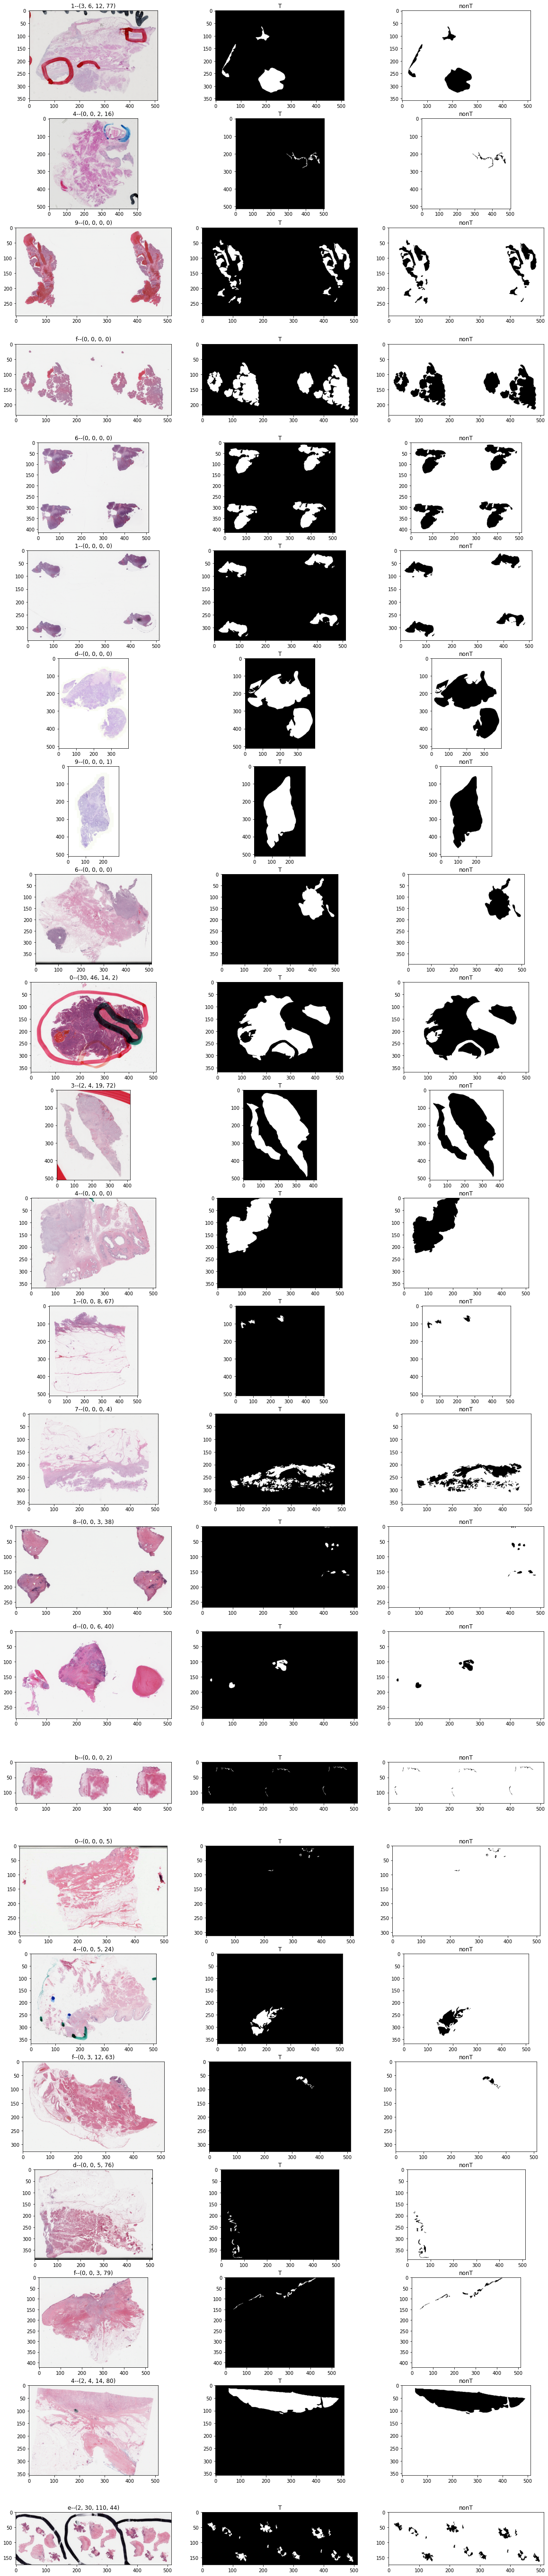

In [31]:
for i,fig in enumerate(figseq):
    if i%3 != 0:
        figseq[i] = visualization.pixel_255(fig,threshold = 0.1)
visualization.ploting(rows = len(figseq)//3,cols=3,figseq = figseq,title= titles,figsize = (20,100))